# Classification and Feature Selection -- Neural Networks
We use Neural Networks for our binary classification of Lung Cancer.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.activations import elu
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from focal_loss import BinaryFocalLoss
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

### 1. Import the dataset

In [2]:
lung = pd.read_csv("dataset/lung_dataset.csv")

In [3]:
first_split, second_split = train_test_split (lung, test_size = 0.4, random_state = 42)
lung_train, lung_test = train_test_split(first_split, test_size = 0.2, random_state = 42)

In [4]:
lung_train.shape, lung_test.shape

((490, 17396), (123, 17396))

In [5]:
X_train = lung_train.drop(['Unnamed: 0', 'DepMap_ID', 'label'], axis = 1)
y_train = lung_train['label']

X_test = lung_test.drop(['Unnamed: 0', 'DepMap_ID', 'label'], axis = 1)
y_test = lung_test['label']

### 2. Ensemble model of Neural Network

The idea is to fit $k + 1$ NNs models:

1. the first one will be the one trained on all lung obs and an equal number of non-lung obs randomly selected
2. ...
3. ...

And so forth up top the $k$-th model. 
We then define the prediction in voting fashion, possibly with a weight (i.e. a vote for lung could count more than a vote for non-lung).

As loss function we use the Focal Loss. Here’s the main idea: in our dataset, we will naturally have some training examples that are easier to classify than others (non-lung). During training, these examples will be classified with 99% accuracy, while other more challenging ones may still exhibit poor performance. The problem is that those easily classified training examples are still contributing to the loss. Why are we still giving them equal weight when there are other more challenging data points that if correctly classified can contribute much more to our overall accuracy?

$$FL(p_t) = \alpha \cdot (1-p_t)^\gamma \cdot \log{p_t}$$

Focal loss down-weights the well-classified examples. This has the net effect of putting more training emphasis on that data that is hard to classify! In a practical setting where we have a data imbalance, our majority class will quickly become well-classified since we have much more data for it. Thus, in order to insure that we also achieve high accuracy on our minority class, we can use the focal loss to give those minority class examples more relative weight during training. 

**$k$ undersampling NNs models**

In [16]:
models = []

metrics = [
        keras.metrics.FalseNegatives(name = "fn"),
        keras.metrics.FalsePositives(name = "fp"),
        keras.metrics.TrueNegatives(name = "tn"),
        keras.metrics.TruePositives(name = "tp"),
        keras.metrics.Precision(name = "precision"),
        keras.metrics.Recall(name = "recall"),
    ]

for i in range(30):
    # create random undersampling of majority class
    rus = RandomUnderSampler(random_state=i)
    X_res, y_res = rus.fit_resample(X_train, y_train)


    model_i = keras.Sequential(
    [
        keras.layers.Dense(500, activation="relu", input_shape=(17393,)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(300, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid")
    ]
    )


    model_i.compile(optimizer = "adam", loss = BinaryFocalLoss(gamma = 2), metrics = metrics)

    model_i.fit(X_res, y_res, batch_size = len(X_res), epochs = 40, verbose = 0)

    models.append(model_i)

**Confusion matrix on test**

In [10]:
import itertools
def plot_confusion_matrix(cm, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples):
    
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect = 4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                fontsize = 15,
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
        plt.grid(None)
        plt.tight_layout()
        plt.ylabel('True label', size = 18)
        plt.xlabel('Predicted label', size = 18)

In [17]:
sum_pred = 0
for i in range(len(models)):
    sum_pred += models[i].predict(X_test)

ensemble_prediction = (sum_pred/len(models)) > 0.5 # corresponds to y_pred

In [18]:
print(f'The accuracy of the model is {round(accuracy_score(y_test, ensemble_prediction), 3)*100} %')

print(f'Predicted {ensemble_prediction.sum()} obs out of {y_test.sum()} True obs')

The accuracy of the model is 60.199999999999996 %
Predicted 52 obs out of 9 True obs


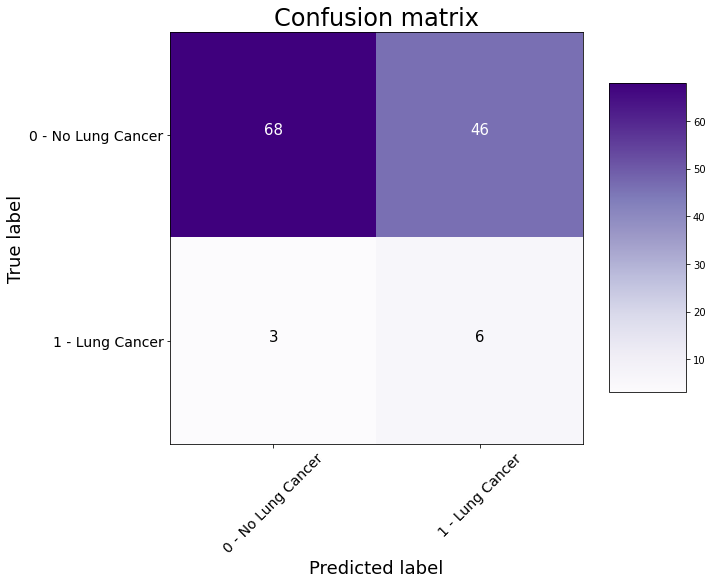

In [19]:
cm = confusion_matrix(y_test, ensemble_prediction)

plot_confusion_matrix(cm, classes = ['0 - No Lung Cancer', '1 - Lung Cancer'])

It completely fails in classifying Lung Cancer cells

In [20]:
def evaluate_model(y_pred, y_test, y_train, train_predictions):
    baseline = {}
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    
    results = {}
    results['recall'] = recall_score(y_test, y_pred)
    results['precision'] = precision_score(y_test, y_pred)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    
    for metric in ['recall', 'precision']:
        print(f'{metric.capitalize()} -- Baseline: {round(baseline[metric], 3)}, Test: {round(results[metric], 3)}, Train: {round(train_results[metric], 3)}')

In [21]:
sum_pred_train = 0
for i in range(len(models)):
    sum_pred_train += models[i].predict(X_train)

ensemble_prediction_train = (sum_pred_train/len(models)) > 0.5 # corresponds to train_predictions

In [22]:
evaluate_model(ensemble_prediction, y_test, y_train, ensemble_prediction_train)

Recall -- Baseline: 1.0, Test: 0.667, Train: 0.982
Precision -- Baseline: 0.073, Test: 0.115, Train: 0.312
